## Import Sedona

In [1]:
import os
import socket
from sedona.spark import *
import rasterio
import numpy as np
from shapely.geometry import Point, Polygon
from sedona.spark import *
from IPython.display import display, HTML

## Create a Sedona Context object.
If you already have a spark instance available, simply use ```SedonaContext.create(spark)```.

In [2]:
spark_endpoint = "spark://spark-master.spark.svc.cluster.local:7077"

s3_endpoint = os.environ["JUPYTERLAB_S3_ENDPOINT"]
s3_access_key_id = os.environ["JUPYTERLAB_S3_ACCESS_KEY_ID"]
s3_secret_access_key = os.environ["JUPYTERLAB_S3_SECRET_ACCESS_KEY"]

config = (
    SedonaContext.builder()
    .master(spark_endpoint) \
    .appName("RasterProcessingWithSedona") \
    .config("spark.driver.host", socket.gethostbyname(socket.gethostname())) \
    .config("spark.driver.port", "2222") \
    .config("spark.blockManager.port", "36859") \
    .config("spark.executor.memory", "16g") \
    .config("spark.executor.cores", "4") \
    .config("spark.driver.memory", "10g") \
    .config("spark.hadoop.fs.s3a.endpoint", s3_endpoint) \
    .config("spark.hadoop.fs.s3a.access.key", s3_access_key_id) \
    .config("spark.hadoop.fs.s3a.secret.key", s3_secret_access_key) \
    .config("spark.hadoop.fs.s3a.connection.ssl.enabled", "false") \
    .config("spark.hadoop.fs.s3a.path.style.access", "true") \
    .config(
        'spark.jars.packages',
        'org.apache.sedona:sedona-spark-shaded-3.5_2.12:1.6.1,'
        'org.datasyslab:geotools-wrapper:1.6.1-28.2'
    )
    .getOrCreate()
)

sedona = SedonaContext.create(config)

sc = sedona.sparkContext

# Check if the application is connected to the Spark master
def check_spark_connection():
    try:
        # Access the master URL and application ID
        master_url = sc.master
        app_id = sc.applicationId
        
        print(f"Connected to Spark Master at: {master_url}")
        print(f"Application ID: {app_id}")
        return True
    except Exception as e:
        print("Failed to connect to the Spark cluster.")
        print(f"Error: {e}")
        return False
    
# Run the connection check
if check_spark_connection():
    print("Spark connection successful.")
else:
    print("Failed to connect to Spark. Exiting...")
    spark.stop()  # Stop the Spark session if connection fails
    exit(1)

Connected to Spark Master at: spark://spark-master.spark.svc.cluster.local:7077
Application ID: app-20250102132455-0001
Spark connection successful.


## Read GeoTiff files

In [3]:
raster_path = "s3a://tithia-data/cmip6_climate_prec_ssp126_accesscm2_apr_2021_2040_20000.tif"

geotiff_df = sedona.read.format("binaryFile").load(raster_path)
geotiff_df.show(2)
geotiff_df.createOrReplaceTempView("binary_raster")

+--------------------+-------------------+-------+--------------------+
|                path|   modificationTime| length|             content|
+--------------------+-------------------+-------+--------------------+
|s3a://tithia-data...|2025-01-02 13:19:54|1902819|[49 49 2A 00 08 0...|
+--------------------+-------------------+-------+--------------------+



## Create raster columns from the read binary data

In [4]:
raster_df = sedona.sql("SELECT RS_FromGeoTiff(content) as raster from binary_raster")
raster_df.show(2)
raster_df.createOrReplaceTempView("raster_table")

+--------------------+
|              raster|
+--------------------+
|GridCoverage2D["g...|
+--------------------+



## Operate on rasters using Sedona
Once a raster column is created, you're now free to use the entire catalog of Sedona's [raster functions](https://sedona.apache.org/1.5.0/api/sql/Raster-operators/). The following part of notebook contains a few examples.

### Access raster metadata
[RS_MetaData](https://sedona.apache.org/1.5.0/api/sql/Raster-operators/#rs_metadata) can be used to view the loaded raster's metadata (orientation and georeferencing attributes).

In [5]:
raster_metadata = sedona.sql("SELECT RS_MetaData(raster) as metadata from raster_table")
metadata = raster_metadata.first()[0]
raster_srid = metadata[8]
metadata

Row(upperLeftX=-180.0, upperLeftY=89.0, gridWidth=2160, gridHeight=1068, scaleX=0.16666666666666666, scaleY=-0.16666666666666666, skewX=0.0, skewY=0.0, srid=4326, numSampleDimensions=1, tileWidth=256, tileHeight=256)

### Visualize rasters
Sedona 1.5.0 provides [multiple ways to be able to visualize rasters](https://sedona.apache.org/1.5.0/api/sql/Raster-visualizer/). Throughout this notebook, [RS_AsImage](https://sedona.apache.org/1.5.0/api/sql/Raster-visualizer/#rs_asimage) will be used to visualize any changes to the rasters.

,"rs_asimage(raster, 500)"
0,

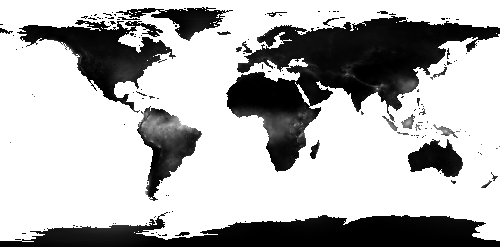

In [6]:
SedonaUtils.display_image(raster_df.selectExpr("RS_AsImage(raster, 500)"))

### Join based on raster predicates
Sedona 1.5.0 now supports join predicates between raster and geometry columns.

Below is a simple example that carves a small rectangle from the existing raster and attempts to join it with the original raster

In [7]:
(width, height) = sedona.sql(
    "SELECT RS_Width(raster) as width, RS_Height(raster) as height from raster_table"
).first()
(p1X, p1Y) = sedona.sql(
    f"SELECT RS_RasterToWorldCoordX(raster, {width / 2}, {height / 2}) \
                  as pX, RS_RasterToWorldCoordY(raster, {width / 2}, {height / 2}) as pY from raster_table"
).first()
(p2X, p2Y) = sedona.sql(
    f"SELECT RS_RasterToWorldCoordX(raster, {(width / 2) + 2}, {height / 2}) \
                  as pX, RS_RasterToWorldCoordY(raster, {(width / 2) + 2}, {height / 2}) as pY from raster_table"
).first()
(p3X, p3Y) = sedona.sql(
    f"SELECT RS_RasterToWorldCoordX(raster, {width / 2}, {(height / 2) + 2}) \
                  as pX, RS_RasterToWorldCoordY(raster, {width / 2}, {(height / 2) + 2}) as pY from raster_table"
).first()
(p4X, p4Y) = sedona.sql(
    f"SELECT RS_RasterToWorldCoordX(raster, {(width / 2) + 2}, {(height / 2) + 2}) \
                  as pX, RS_RasterToWorldCoordY(raster, {(width / 2) + 2}, {(height / 2) + 2}) as pY from raster_table"
).first()

In [8]:
geom_wkt = f"SRID={int(raster_srid)};POLYGON (({p1X} {p1Y}, {p2X} {p2Y}, {p3X} {p3Y}, {p4X} {p4Y}, {p1X} {p1Y}))"

In [9]:
geom_df = sedona.sql(f"SELECT ST_GeomFromEWKT('{geom_wkt}') as geom")
geom_df.createOrReplaceTempView("geom_table")

In [10]:
joined_df = sedona.sql(
    "SELECT g.geom from raster_table r, geom_table g where RS_Intersects(r.raster, g.geom)"
)
joined_df.show()

+--------------------+
|                geom|
+--------------------+
|POLYGON ((-0.1666...|
+--------------------+



### Interoperability between raster and vector data types
Sedona allows for conversions from raster to geometry and vice-versa. 

### Convert a raster to vector using convex hull
A convex hull geometry can be created out of a raster using [RS_ConvexHull](https://sedona.apache.org/1.5.0/api/sql/Raster-operators/#rs_convexhull)

Additionally, if a raster has noDataValue specified, and you wish to tighten the convexhull to exclude noDataValue boundaries, [RS_MinConvexHull](https://sedona.apache.org/1.5.0/api/sql/Raster-operators/#rs_minconvexhull) can be used.

In [11]:
raster_convex_hull = sedona.sql(
    "SELECT RS_ConvexHull(raster) as convex_hull from raster_table"
)
raster_min_convex_hull = sedona.sql(
    "SELECT RS_MinConvexHull(raster) as min_convex_hull from raster_table"
)
raster_convex_hull.show(truncate=False)
raster_min_convex_hull.show(truncate=False)

+-------------------------------------------------------+
|convex_hull                                            |
+-------------------------------------------------------+
|POLYGON ((-180 89, 180 89, 180 -89, -180 -89, -180 89))|
+-------------------------------------------------------+

+-------------------------------------------------------+
|min_convex_hull                                        |
+-------------------------------------------------------+
|POLYGON ((-180 89, 180 89, 180 -89, -180 -89, -180 89))|
+-------------------------------------------------------+



### Convert a geometry to raster (Rasterize a geometry)
A geometry can be converted to a raster using [RS_AsRaster](https://sedona.apache.org/1.5.0/api/sql/Raster-writer/#rs_asraster)

In [12]:
rasterized_geom_df = sedona.sql(
    "SELECT RS_AsRaster(ST_GeomFromWKT('POLYGON((150 150, 220 260, 190 300, 300 220, 150 150))'), r.raster, 'b', 230) as rasterized_geom from raster_table r"
)
rasterized_geom_df.show()

+--------------------+
|     rasterized_geom|
+--------------------+
|GridCoverage2D["g...|
+--------------------+



,rasterized_geom
0,

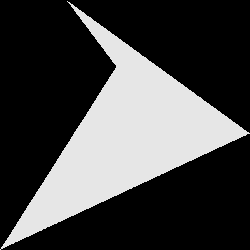

In [13]:
SedonaUtils.display_image(
    rasterized_geom_df.selectExpr("RS_AsImage(rasterized_geom, 250) as rasterized_geom")
)

### Perform Map Algebra operations
Sedona provides two ways to perform [Map Algebra](https://sedona.apache.org/1.5.0/api/sql/Raster-map-algebra/) on rasters:
1. Using RS_MapAlgebra (preferred for simpler algebraic functions)
2. Using RS_BandAsArray and array based map algebra functions such as RS_Add, RS_Multiply (Useful for complex algebriac functions involving mutating each grid value differently.)

The following example illustrates how RS_MapAlgebra can be used. 
This example uses jiffle script to invert the colors of the above illustrated rasterized geometry.

In [14]:
raster_white_bg = rasterized_geom_df.selectExpr(
    "RS_MapAlgebra(rasterized_geom, NULL, 'out[0] = rast[0] == 0 ? 230 : 0;') as raster"
)

,resampled_raster
0,

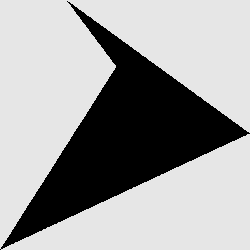

In [15]:
SedonaUtils.display_image(
    raster_white_bg.selectExpr("RS_AsImage(raster, 250) as resampled_raster")
)

### Resample a raster.
Sedona 1.5.0 supports resampling a raster to different height/width or scale. It also supports changing the pivot of the raster.

Refer to [RS_Resample](https://sedona.apache.org/1.5.0/api/sql/Raster-operators/#rs_resample) documentation for more details.

This simple example changes the resolution of the loaded raster to 1000*1000

In [16]:
resampled_raster_df = sedona.sql(
    "SELECT RS_Resample(raster, 1000, 1000, false, 'NearestNeighbor') as resampled_raster from raster_table"
)

,resampled_raster
0,

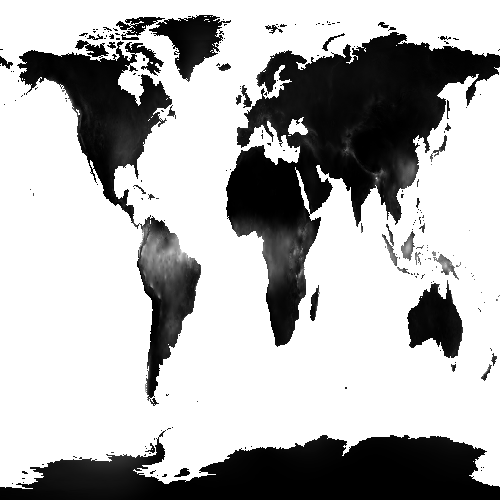

In [17]:
SedonaUtils.display_image(
    resampled_raster_df.selectExpr(
        "RS_AsImage(resampled_raster, 500) as resampled_raster"
    )
)

In [18]:
resampled_raster_df.selectExpr(
    "RS_MetaData(resampled_raster) as resampled_raster_metadata"
).show(truncate=False)

+---------------------------------------------------------------------+
|resampled_raster_metadata                                            |
+---------------------------------------------------------------------+
|{-180.0, 89.0, 1000, 1000, 0.36, -0.178, 0.0, 0.0, 4326, 1, 500, 500}|
+---------------------------------------------------------------------+

